Reference: https://github.com/melanieshi0120/NLP_Analysis_Amazon_Reviews/blob/master/Amazon_sport_product_review.ipynb
data dource: http://jmcauley.ucsd.edu/data/amazon/

In [8]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import pickle
import re, string
import sys
import seaborn as sns
sns.set()
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score

In [10]:
sport_and_outdoor = []
for line in open('Sports_and_Outdoors_5.json', 'r'):
    sport_and_outdoor.append(json.loads(line))

In [11]:
df = pd.DataFrame(sport_and_outdoor)
df.shape

(296337, 9)

In [12]:
# create a new column which combines review and summary
df['combined_text'] = df['reviewText'] + ' ' + df['summary']

In [14]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012",If you don't have a 3/32 punch or would like t...
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012",This works no better than any 3/32 punch you w...
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013",I purchased this thinking maybe I need a speci...


### Data Cleaning

In [15]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
combined_text        0
dtype: int64

There are some reviewrs' names are missing, er will remove reviewName columns

In [16]:
# check how many unique values in rating column
df['overall'].value_counts()

5.0    188208
4.0     64809
3.0     24071
2.0     10204
1.0      9045
Name: overall, dtype: int64

In [17]:
# create a target column based on product_rating, if rating <= 3 means bad: 0 if rating >= 4 good:1
df['target'] = [0 if x <= 3 else 1 for x in df['overall']]

In [18]:
# create a column for helpfulness numerator and helpfulness denominator
df['helpfulness_Numerator'] = [x[0] for x in df['helpful']]
df['helpfulness_Denomintor'] = [x[1] for x in df['helpful']]

In [19]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text,target,helpfulness_Numerator,helpfulness_Denomintor
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...,1,0,0
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...,1,1,1
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012",If you don't have a 3/32 punch or would like t...,1,2,2
3,A148SVSWKTJKU6,1881509818,"Jusitn A. Watts ""Maverick9614""","[0, 0]",This works no better than any 3/32 punch you w...,4.0,It's a punch with a Glock logo.,1328400000,"02 5, 2012",This works no better than any 3/32 punch you w...,1,0,0
4,AAAWJ6LW9WMOO,1881509818,Material Man,"[0, 0]",I purchased this thinking maybe I need a speci...,4.0,"Ok,tool does what a regular punch does.",1366675200,"04 23, 2013",I purchased this thinking maybe I need a speci...,1,0,0


### Review Counts by Rating

Text(0.5, 1.0, 'Review Counts by Rating')

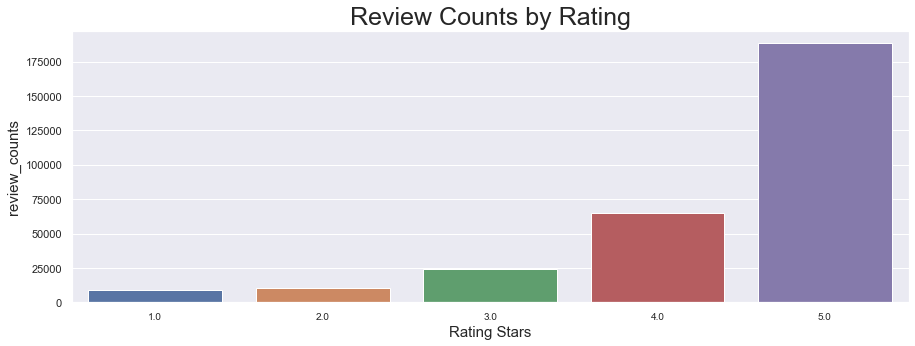

In [25]:
# plot review counts in different rating group
rating = pd.DataFrame(df['overall'].value_counts()).reset_index().sort_values(by='index', ascending=True)
plt.figure(figsize=(15,5))
sns.barplot(rating['index'], rating['overall'])
plt.xticks(fontsize=10)
plt.xlabel('Rating Stars', fontsize=15)
plt.ylabel('review_counts', fontsize=15)
plt.title('Review Counts by Rating', fontsize=25)

In [28]:
# plot review counts in bad review group and good review group
bad_good = pd.DataFrame(df['target'].value_counts()).reset_index().sort_values(by='index', ascending=False)
sns.barplot(bad_good['index'], bad_good['target'])
plt.xticks([0,1], ['Bad Reviews', 'Good Reviews'], fontsize=15)
plt.ylabel('review_counts', fontsize=15)
plt.title('Review Counts by Bad.Good Reviews', fontsize=20)